In [1]:
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

## Util to generate random data

In [4]:
random_gen = np.random.default_rng(12341)
def random_dataset(N):
    attributes = random_gen.random(size = (N, 25))
    timeseries = random_gen.random(size = (N, 60))
    folds = np.array_split(np.arange(0, N, dtype= 'int'), 5)
    return attributes, timeseries, folds

## Experiment interface to easily run experiments

In [5]:
from sklearn.tree import DecisionTreeRegressor
from pathlib import Path



experiment = (
    ComparisonExperiment(result_path = Path('results/first_test'), nb_of_samples = 250)
    .add_methods(
        predictive_clustering =  PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100)),
        deep_predictive_clustering = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 100)),
        random_baseline = RandomGenerator(),
    )
    .add_datasets(
        random_dataset = random_dataset(1000),
        deep_random_dataset = random_dataset(10000)
    )
)

energy_scores, timing_df = experiment.execute()




Methods: 100%|████████████| 3/3 [00:00<00:00, 30.74it/s, method=random_baseline]


In [6]:
energy_scores.mean(axis = 0)

predictive_clustering       random_dataset         1.600256
                            deep_random_dataset    1.586180
deep_predictive_clustering  random_dataset         1.600099
                            deep_random_dataset    1.595053
random_baseline             random_dataset         1.587108
                            deep_random_dataset    1.583526
dtype: float64

In [7]:
timing_df

training_time  predict_time  \
predictive_clustering      random_dataset            0.061019      0.050253   
                           deep_random_dataset       0.954830      0.212758   
deep_predictive_clustering random_dataset            0.057783      0.035363   
                           deep_random_dataset       1.554065      0.225117   
random_baseline            random_dataset            0.001014      0.002900   
                           deep_random_dataset       0.009206      0.016619   

                                                eval_time  
predictive_clustering      random_dataset        1.691875  
                           deep_random_dataset  11.465797  
deep_predictive_clustering random_dataset        1.303460  
                           deep_random_dataset  11.162136  
random_baseline            random_dataset        1.209708  
                           deep_random_dataset  11.206723

## Use model directly
PredClusGenerator return indices into the training data as samples

In [8]:
model =  PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100))
attributes, timeseries, _ = random_dataset(1000)
model.fit(attributes, timeseries)

test_attributes = np.random.random(size = (1, attributes.shape[1]))
indices = model.generate(test_attributes, nb_of_samples=100)
indices

array([[686, 878, 430, 842,  27, 945, 967, 575, 183, 430, 979, 948, 853,
        822, 878, 807, 103, 878, 448, 431, 222,  26, 767, 472, 222, 666,
        767, 428, 443, 767, 378, 395, 537, 997,  26, 210, 288, 501, 656,
         91, 866, 183, 210, 763, 997, 631, 784, 192,  27, 547, 594, 902,
        590, 464, 378, 822, 551, 587, 656, 459, 986, 686,  91, 106, 242,
        686, 551, 206, 549, 698, 448, 388, 228, 399, 395, 662, 448,  99,
        767, 624, 210, 878, 431, 853, 575, 299,  27, 387, 439, 948, 979,
        656, 547, 590,  27, 222, 939, 183, 594, 784]])

In [9]:
timeseries[indices]

array([[[0.2415198 , 0.75387274, 0.26422107, ..., 0.96814494,
         0.67340923, 0.36798739],
        [0.99780454, 0.280338  , 0.90977746, ..., 0.67024508,
         0.31100458, 0.53114583],
        [0.20877777, 0.18014385, 0.2944819 , ..., 0.80748466,
         0.28548786, 0.10630231],
        ...,
        [0.248911  , 0.99671839, 0.40318031, ..., 0.19930912,
         0.51447441, 0.76210028],
        [0.00557693, 0.65897661, 0.20228979, ..., 0.57175415,
         0.23961878, 0.21937   ],
        [0.57300573, 0.54048898, 0.74094221, ..., 0.11522324,
         0.79037419, 0.75520914]]])

## Or use SampleGenerator

In [10]:
model =  SampleGenerator(PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100)))
attributes, timeseries, _ = random_dataset(1000)
model.fit(attributes, timeseries)

test_attributes = np.random.random(size = (1, attributes.shape[1]))
timeseries = model.generate_timeseries(test_attributes, nb_of_samples=100)
timeseries

array([[[0.43598369, 0.60072358, 0.31484912, ..., 0.42516335,
         0.52254863, 0.66331509],
        [0.6951836 , 0.20883989, 0.66906737, ..., 0.75085161,
         0.31178081, 0.12893107],
        [0.28331309, 0.74695556, 0.55673988, ..., 0.65450282,
         0.12120573, 0.75807615],
        ...,
        [0.08286575, 0.23712262, 0.20793288, ..., 0.91949695,
         0.11382682, 0.53372636],
        [0.75697657, 0.46873517, 0.17631605, ..., 0.55037928,
         0.53166968, 0.2767308 ],
        [0.14158569, 0.0125864 , 0.11432212, ..., 0.24642059,
         0.38376258, 0.16403611]]])

# Interpretability

This package also contains a few utilities to help interpret the resulting model 

In [11]:
# fit a model
model =  PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100))
attributes, timeseries, _ = random_dataset(1000)
model.fit(attributes, timeseries)

In [12]:
# for interpretability feature names are required
attribute_df = pd.DataFrame(attributes, columns = [f"attr{i}" for i in range(attributes.shape[1])])
attribute_df

,attr0,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,...,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24
0,0.900883,0.579304,0.981243,0.604337,0.228136,0.527990,0.862140,0.116562,0.438714,0.694746,...,0.116647,0.724818,0.880297,0.845364,0.901087,0.523532,0.325197,0.681547,0.465153,0.495952
1,0.846325,0.365613,0.743619,0.968505,0.198840,0.972674,0.318804,0.235581,0.435145,0.360923,...,0.951097,0.552413,0.749836,0.001554,0.911510,0.319231,0.136199,0.336776,0.243565,0.014090
2,0.599070,0.086467,0.000698,0.361318,0.991688,0.765150,0.232925,0.797855,0.744841,0.593621,...,0.371171,0.712341,0.786580,0.483663,0.309702,0.726471,0.839932,0.128212,0.988604,0.939474
3,0.871337,0.115934,0.619605,0.976076,0.184401,0.748886,0.577401,0.781689,0.555699,0.305838,...,0.505073,0.158089,0.480146,0.532069,0.818749,0.873275,0.672326,0.974249,0.914695,0.061930
4,0.665427,0.337792,0.784562,0.737917,0.151080,0.711425,0.532877,0.619332,0.977759,0.246525,...,0.021729,0.077137,0.927293,0.121515,0.870603,0.292752,0.934475,0.063880,0.381937,0.716201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.713562,0.630738,0.228696,0.572606,0.953009,0.143299,0.737865,0.837683,0.660303,0.817469,...,0.099958,0.843026,0.472556,0.514108,0.673982,0.692214,0.000366,0.850794,0.879485,0.840036
996,0.036723,0.852547,0.849143,0.377178,0.065597,0.170670,0.375298,0.721524,0.250171,0.835108,...,0.918408,0.694101,0.522319,0.804866,0.997517,0.786573,0.209955,0.882162,0.567388,0.784201
997,0.940979,0.108860,0.280657,0.413787,0.565952,0.829288,0.773733,0.722288,0.482624,0.000565,...,0.401912,0.227091,0.466422,0.409052,0.053874,0.527519,0.480707,0.116499,0.700471,0.919007
998,0.321948,0.782206,0.537420,0.157452,0.289603,0.579328,0.068567,0.667490,0.764037,0.163963,...,0.953138,0.458727,0.516644,0.898312,0.956436,0.577646,0.623550,0.424661,0.889858,0.081319


In [14]:
vistree = model.to_visualization_tree(attribute_df)
vistree

## For easy visualization you can compress the tree 
This operation compresses multiple binary splits on the same attribute to a single n-ary split  
(in this random examples this won't have any influence on the result)

In [18]:
vistree = vistree.compress_tree()

## quick visualization with printing

In [19]:
vistree.print_tree()

 -  attr22 <= 0.6903134882450104
	 -  attr17 <= 0.531973272562027
		 -  attr1 <= 0.6982715427875519
			 -  attr24 <= 0.48257778584957123
			 -  attr24 > 0.48257778584957123
		 -  attr1 > 0.6982715427875519
	 -  attr17 > 0.531973272562027
		 -  attr16 <= 0.40566296875476837
		 -  attr16 > 0.40566296875476837
			 -  attr8 <= 0.4680955111980438
			 -  attr8 > 0.4680955111980438
 -  attr22 > 0.6903134882450104
	 -  attr8 <= 0.6549617350101471
	 -  attr8 > 0.6549617350101471


## More extensive visualization through plotting

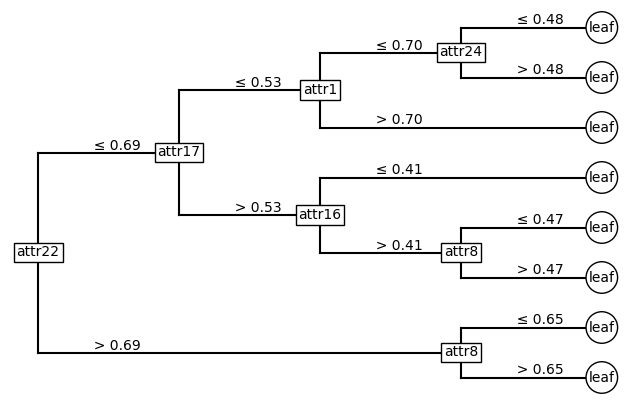

In [28]:
vistree.plot_tree(figsize = (8,5)) # You might have to tinker with the aspect ratio and size to get a readeable figure 

## In this tree the individual nodes have more precise plotting functionalities

In [35]:
vistree.root_node.plot_attribute_distribution(attribute_df)

/home/jonas/miniconda3/envs/scengen/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [37]:
vistree.root_node.children[0][2].children[0][2].plot_attribute_distribution(attribute_df)

/home/jonas/miniconda3/envs/scengen/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)